#**Entrainer et gérer mes modèles avec MLFLOW**

###**Librairies nécessaires**

In [9]:
# libriaries nécessaires pour la manipulation
import numpy as np
import pandas as pd
# Pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer # Encodage des variables catégorielles
from sklearn.impute import SimpleImputer # Gérer les NaNs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold # Pour diviser le dataset en pli
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import RocCurveDisplay, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

import gc  # Pour libérer la mémoire
import os # Gestion du système de fichiers du drive

# Supprimer les avertissements
import warnings
warnings.filterwarnings('ignore')

import joblib

**Repertoire de travail**

In [2]:
# Connecter à googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Notre répertoire de travail
chemin = r"/content/gdrive/MyDrive/Colab Notebooks/Projet_OPC/P7_Implémentez_modele_Scoring/Data"

# Liste des fichiers ou dossier à l'intérieur
os.listdir(chemin)

**Chargement des données**

In [4]:
# %%
# Chargement des données
data = pd.read_pickle(chemin + '/train_red_format.pkl')
print('Dimension des données: ', data.shape)
data.head()


Dimension des données:  (244774, 14)


,SK_ID_CURR,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_mean,bureau_CREDIT_ACTIVE_Closed_mean,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,bureau_CREDIT_ACTIVE_Active_mean
0,100002,1,0.139404,0.262939,-9461.0,-103.0,-1437.0,-500.0,-874.0,0.750000,Cash loans,M,N,0.250000
2,100004,0,0.729492,0.556152,-19046.0,-408.0,-1326.0,-532.0,-867.0,1.000000,Revolving loans,M,Y,0.000000
5,100008,0,0.621094,0.354248,-16941.0,-78.0,-1097.0,-611.0,-757.5,0.666504,Cash loans,M,N,0.333252
6,100009,0,0.491943,0.724121,-13778.0,-239.0,-2882.0,-851.5,-1272.0,0.777832,Cash loans,F,Y,0.222168
7,100010,0,0.540527,0.714355,-18850.0,-1138.0,-2740.0,-578.0,-1940.0,0.500000,Cash loans,M,Y,0.500000


**Pre-processing**

In [5]:
# Séparer les colonnes numériques et catégoriques
df = data.copy()
categorical_cols = df.select_dtypes(include = "object").columns
numeric_cols = df.drop(['TARGET', 'SK_ID_CURR'], axis = 1).select_dtypes(exclude = "object").columns

print(numeric_cols)
print(categorical_cols)

# %%
# Encodage des catégorielles avec One-Hot
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.info()

# %%
df['NAME_CONTRACT_TYPE_Revolving loans'].unique()


# %% Normalisation des données numériques
# Instancier le scaler
scaler = MinMaxScaler()

# Normaliser uniquement les colonnes numériques
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'bureau_DAYS_CREDIT_max',
       'bureau_DAYS_CREDIT_min', 'bureau_DAYS_CREDIT_UPDATE_mean',
       'bureau_DAYS_CREDIT_mean', 'bureau_CREDIT_ACTIVE_Closed_mean',
       'bureau_CREDIT_ACTIVE_Active_mean'],
      dtype='object')
Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 244774 entries, 0 to 307510
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   SK_ID_CURR                          244774 non-null  int32  
 1   TARGET                              244774 non-null  int8   
 2   EXT_SOURCE_3                        244774 non-null  float16
 3   EXT_SOURCE_2                        244774 non-null  float16
 4   DAYS_BIRTH                          244774 non-null  float32
 5   bureau_DAYS_CREDIT_max              244774 non-null  float16
 6   bu

###**Spliter le dataset**

In [6]:
# Séparation X (features) et y (cible)
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])  # Exclure la cible et l'identifiant client
y = df['TARGET']

seed = 123
# Division en jeux d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y  # Stratify pour garder le déséquilibre
)

print(f"Taille du jeu d'entraînement : {X_train.shape}")
print(f"Taille du jeu de test : {X_test.shape}")

Taille du jeu d'entraînement : (195819, 13)
Taille du jeu de test : (48955, 13)


In [7]:
X_test

,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_mean,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_ACTIVE_Active_mean,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y
191642,0.832599,0.737864,0.122682,0.841205,0.140411,0.967114,0.429110,0.888672,0.000000,False,False,False,False
183535,0.363931,0.740148,0.080171,0.981520,0.748288,0.996695,0.901712,0.500000,0.500000,False,False,False,False
229083,0.488800,0.582524,0.078916,0.964408,0.005479,0.974178,0.517466,0.714355,0.285645,False,False,False,False
161049,0.835871,0.854940,0.650442,0.431211,0.151370,0.988843,0.291096,1.000000,0.000000,False,True,False,False
88672,0.576863,0.681324,0.840685,0.549623,0.128082,0.982113,0.339041,1.000000,0.000000,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118750,0.860954,0.698458,0.579515,0.731691,0.236301,0.982889,0.459589,0.833496,0.166626,False,False,False,False
83242,0.534876,0.881211,0.753609,0.956879,0.616781,0.997260,0.833647,0.600098,0.399902,False,False,False,False
238898,0.492889,0.545973,0.362682,0.934976,0.592466,0.989702,0.758390,0.250000,0.750000,False,False,False,False
239959,0.803154,0.366932,0.245649,0.912389,0.115068,0.983175,0.494521,0.500000,0.500000,False,False,False,False


**Entrainement**

In [10]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


**LGBMClassifier**

In [32]:
# %% Entraînement du modèle
# Instancier le modèle avec pondération des classes
model = lgb.LGBMClassifier(
    class_weight='balanced',  # Gestion automatique du déséquilibre
    random_state=seed
)
# Entraîner le modèle
model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15214, number of negative: 180605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 195819, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', random_state=123)

In [33]:
# Prédictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilité pour la classe 1
y_pred_proba[:5]


array([0.18543678, 0.46722985, 0.23374739, 0.26513908, 0.38210073])

**Evaluation du modèle**

**1. Classification report**

In [34]:
# Classification report
print("Classification Report :\n", classification_report(y_test, y_pred))

Classification Report :
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     45152
           1       0.15      0.64      0.25      3803

    accuracy                           0.70     48955
   macro avg       0.56      0.67      0.53     48955
weighted avg       0.90      0.70      0.77     48955



**2. Matrice de confusion**

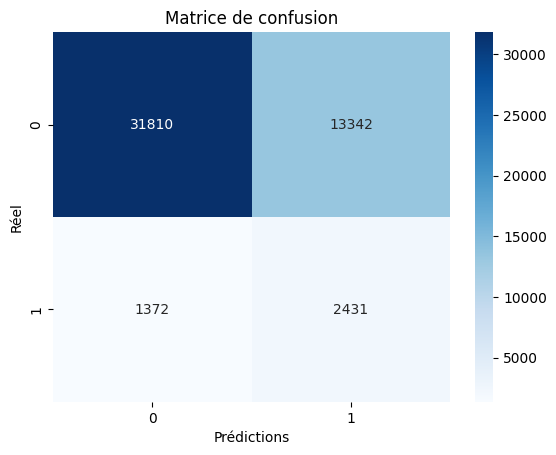

In [31]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show();

**3. Courbe ROC et AUC**

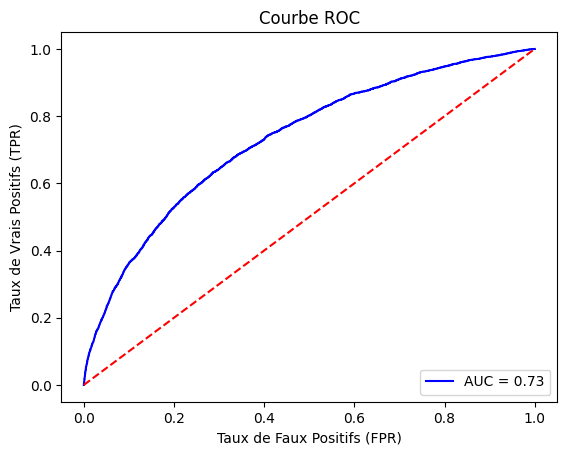

In [35]:
# Courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.show();

# UN AUC-ROC de 0.74 montre que les classes sont bien séparées

**4. Courbe Précision-Rappel**

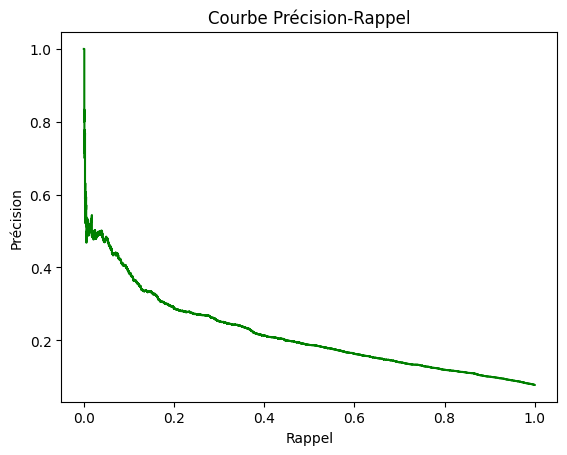

In [36]:
# Courbe Précision-Rappel
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, color='green')
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel")
plt.show();

**5. Évaluation avec F2 et F3**

In [37]:
# %% Évaluation avec les métriques F2 et F3

f2 = fbeta_score(y_test, y_pred, beta=2)  # F2-score
f3 = fbeta_score(y_test, y_pred, beta=3)  # F3-score

# Affichage des résultats
print("=== Scores supplémentaires ===")
print(f"F2-score : {f2:.4f}")
print(f"F3-score : {f3:.4f}")

# F2-score : 0.3984
# F3-score : 0.4945
# le score F2 est plus élevé que le F1, ce qui signifie que
# le modèle est plus performant pour la classe minoritaire


=== Scores supplémentaires ===
F2-score : 0.3923
F3-score : 0.4862


**Optimisation des hyperparamètres**

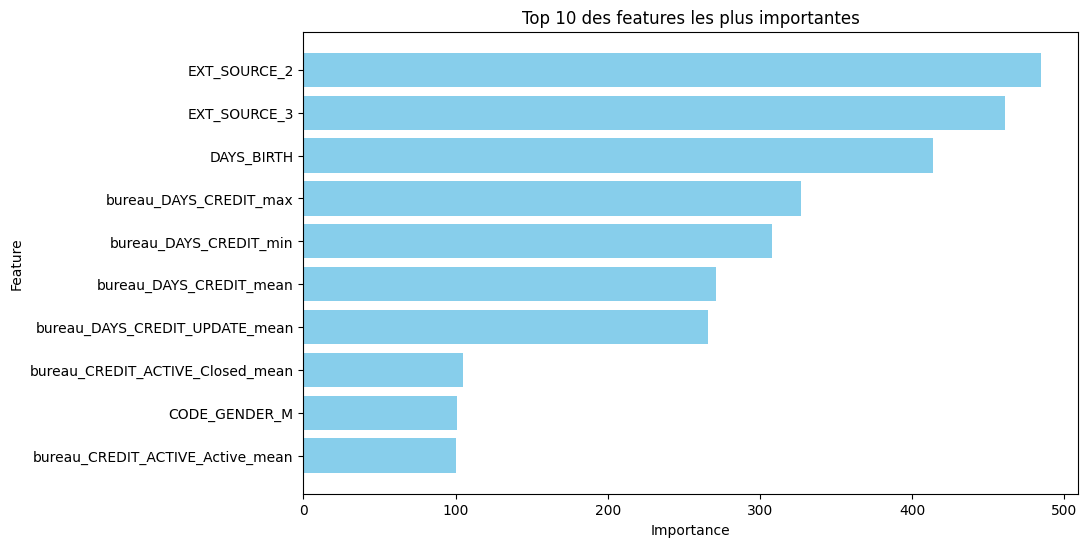

In [38]:
#  Récupérer les importances des features
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

# # Affichage des 10 features les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10][::-1], feature_importances['Importance'][:10][::-1], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 des features les plus importantes")
plt.show();


#### **Réduction des features et réentraînement**

In [39]:
# Liste des 10 features les plus importantes
top_features = feature_importances['Feature'][:10].tolist()

# Sous-ensemble des données d'entraînement et de test
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# # Réinitialisation du modèle avec les meilleurs paramètres trouvés
optimized_model = lgb.LGBMClassifier(
    learning_rate=0.1,
    max_depth=20,
    n_estimators=200,
    num_leaves=70,
    class_weight='balanced',  # Pour compenser le déséquilibre des classes
    random_state=42
)

# Réentraînement
optimized_model.fit(X_train_top, y_train)

# Prédictions
y_pred_top = optimized_model.predict(X_test_top)
y_pred_proba_top = optimized_model.predict_proba(X_test_top)[:, 1]

[LightGBM] [Info] Number of positive: 15214, number of negative: 180605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 195819, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [40]:
# Affichage des performances
f2_top = fbeta_score(y_test, y_pred_top, beta=2)
f3_top = fbeta_score(y_test, y_pred_top, beta=3)
print(f"F2-score (top features) : {f2_top:.4f}")
print(f"F3-score (top features) : {f3_top:.4f}")

F2-score (top features) : 0.3794
F3-score (top features) : 0.4576


In [41]:
# %% Voir la répartition des vraies et fausses prédictions par classe
## Classification report
report = classification_report(y_test, y_pred_top)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_top)
print("Confusion Matrix:\n", cm)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84     45152
           1       0.16      0.58      0.25      3803

    accuracy                           0.73     48955
   macro avg       0.56      0.66      0.54     48955
weighted avg       0.89      0.73      0.79     48955

Confusion Matrix:
 [[33671 11481]
 [ 1611  2192]]


In [42]:
# Ajustement du seuil (exemple à 0.3 pour favoriser la classe minoritaire)
y_pred_adjusted = (y_pred_proba_top >= 0.3).astype(int)

# Calcul du F2-score avec le nouveau seuil
f2_adjusted = fbeta_score(y_test, y_pred_adjusted, beta=2)
f3_adjusted = fbeta_score(y_test, y_pred_adjusted, beta=3)
print(f"F2-score avec seuil ajusté : {f2_adjusted:.4f}")
print(f"F3-score avec seuil ajusté : {f3_adjusted:.4f}")

F2-score avec seuil ajusté : 0.3600
F3-score avec seuil ajusté : 0.5011


In [ ]:
# # Sauvegarde du modèle
# joblib.dump(optimized_model, 'lgb_model.pkl')

# # %%# Chargement du modèle
# model_loaded = joblib.load('lgb_model.pkl')

# # Vérification du chargement avec une prédiction
# sample_data = np.array([[0.1, 30, 0.3, 100, 500, 250, 1000, 1, 0, 2]])  # Exemple de données
# prediction = model_loaded.predict(sample_data)
# print("Prédiction du modèle chargé :", prediction)


**Regression Logistique**

In [52]:
# Entraînement du modèle
clf = LogisticRegression(random_state=seed)
clf.fit(X_train, y_train)

2024/12/28 18:13:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '78338c9a951545edbaf02754cc0baf03', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


LogisticRegression(random_state=123)

In [53]:
y_pred_clf = clf.predict(X_test)
f2_log = fbeta_score(y_test, y_pred_clf, beta=2)
f3_log = fbeta_score(y_test, y_pred_clf, beta=3)
# y_pred_proba_log = clf.predict_proba(X_test)[:, 1]
print(f"F2-score (Regression Logistique) : {f2_log:.4f}")
print(f"F3-score (Regression Logistique) : {f3_log:.4f}")

F2-score (Regression Logistique) : 0.0039
F3-score (Regression Logistique) : 0.0035


**Tracking avec mlflow**

In [88]:
# Tracking avec mlflow
import mlflow
import mlflow.sklearn
import mlflow.lightgbm
from sklearn.metrics import accuracy_score, f1_score
mlflow.set_experiment("Modeles") # Nom de ma branche

<Experiment: artifact_location='file:///content/mlruns/407454828257027944', creation_time=1735419799132, experiment_id='407454828257027944', last_update_time=1735419799132, lifecycle_stage='active', name='Modeles', tags={}>

**Regression Logistique**

In [89]:
# Créer mon exécution avec un nom à defaut
# Appel à l'api de slearn de mlflow qui integre tous les modules de sklearn
mlflow.sklearn.autolog()

# Premier run
with mlflow.start_run(run_name="reg_log_defaut"):
  # Entraînement du modèle
  clf = LogisticRegression(random_state=seed)
  clf.fit(X_train, y_train)


2024/12/28 21:31:29 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [90]:
# On va faire un second run
with mlflow.start_run(run_name="reg_log_maxiter200"):
  clf_2 = LogisticRegression(random_state=seed, max_iter = 200)
  clf_2.fit(X_train, y_train)

**LGBMClassifier**

In [91]:
# Un troisième run
# Activation de l'autolog pour LightGBM
mlflow.lightgbm.autolog()

with mlflow.start_run(run_name="lgb_balanced"):
  lgb_1 = lgb.LGBMClassifier(
                  class_weight='balanced',  # Gestion automatique du déséquilibre
                  random_state=seed)
  lgb_1.fit(X_train, y_train)

    # Prédictions sur les données de test
  y_pred = lgb_1.predict(X_test)

  # Calcul des métriques
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average="weighted")

  # Log des métriques dans MLflow
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("f1_score", f1)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15214, number of negative: 180605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 195819, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [92]:
# Un quatrième run
with mlflow.start_run(run_name="lgb_optimized"):
  optimized_model = lgb.LGBMClassifier(
      learning_rate=0.1,
      max_depth=20,
      n_estimators=200,
      num_leaves=70,
      class_weight='balanced',  # Pour compenser le déséquilibre des classes
      random_state=42)

  optimized_model.fit(X_train_top, y_train)

    # Prédictions sur les données de test
  y_pred_opt = optimized_model.predict(X_test_top)

  # Calcul des métriques
  acc_opt = accuracy_score(y_test, y_pred_opt)
  f1_opt = f1_score(y_test, y_pred_opt, average="weighted")

  # Log des métriques dans MLflow
  mlflow.log_metric("accuracy", acc_opt)
  mlflow.log_metric("f1_score", f1_opt)

[LightGBM] [Info] Number of positive: 15214, number of negative: 180605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 195819, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


**Allons voir dans l'UI mlflow** pour voir ce que ça donne avec **ngrok**:

In [15]:
!pip install pyngrok

In [93]:
# On crée un ngrok  dans https://dashboard.ngrok.com/auth puis le code de "your authtoken"
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

#
NGROK_AUTH_TOKEN  = '2qqxhNrwNmvZFKJQoavME6A7bAh_3jMsGH7o95sJ9Pbtj6zDJ'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://0622-34-125-133-184.ngrok-free.app


**Insterface ui de MLFLOW**

Une fois la cellule, ci-dessous exécutée, on clique sur le lien ci-dessus.

In [94]:
!mlflow ui

[2024-12-28 21:32:43 +0000] [91903] [INFO] Starting gunicorn 23.0.0
[2024-12-28 21:32:43 +0000] [91903] [INFO] Listening at: http://127.0.0.1:5000 (91903)
[2024-12-28 21:32:43 +0000] [91903] [INFO] Using worker: sync
[2024-12-28 21:32:43 +0000] [91908] [INFO] Booting worker with pid: 91908
[2024-12-28 21:32:43 +0000] [91909] [INFO] Booting worker with pid: 91909
[2024-12-28 21:32:43 +0000] [91910] [INFO] Booting worker with pid: 91910
[2024-12-28 21:32:43 +0000] [91911] [INFO] Booting worker with pid: 91911
[2024-12-28 21:37:42 +0000] [91903] [INFO] Handling signal: int
[2024-12-28 21:37:42 +0000] [91908] [INFO] Worker exiting (pid: 91908)
[2024-12-28 21:37:42 +0000] [91911] [INFO] Worker exiting (pid: 91911)
[2024-12-28 21:37:42 +0000] [91910] [INFO] Worker exiting (pid: 91910)
[2024-12-28 21:37:42 +0000] [91909] [INFO] Worker exiting (pid: 91909)

Aborted!
[2024-12-28 21:37:43 +0000] [91903] [INFO] Shutting down: Master
